### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

#### Задание:

Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели предсказать цены для квартир из файла test.csv.

#### Целевая переменная:

Price

#### Метрика:

R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Сдача проекта:

1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

#### Сроки и условия сдачи:

Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").

Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.

При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.

Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.

Успешный проект нельзя пересдать в целях повышения результата.

Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.

В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

#### Примечание:

Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#### Рекомендации для файла с кодом (ipynb):

1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения, которые были в курсе Python для Data Science. Градиентный бустинг изучается в последующих курсах, поэтому в этом проекте его применять не следует. Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

#### Описания полей датасета по недвижимости

__Id__ - идентификационный номер квартиры,

__DistrictId__ - идентификационный номер района,

__Rooms__ - количество комнат,

__Square__ - площадь,

__LifeSquare__ - жилая площадь,

__KitchenSquare__ - площадь кухни,

__Floor__ - этаж,

__HouseFloor__ - количество этажей в доме,

__HouseYear__ - год постройки дома,

__Ecology_1__, __Ecology_2__, __Ecology_3__ - экологические показатели местности,

__Social_1__, __Social_2__, __Social_3__ - социальные показатели местности,

__Healthcare_1__, __Helthcare_2__ - показатели местности, связанные с охраной здоровья,

__Shops_1__, __Shops_2__ - показатели, связанные с наличием магазинов, торговых центров,

__Price__ - цена квартиры.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

### Загрузка данных

Функция загрузки датасета с подготовкой данных для очистки.

На этом этапе для нас важно убрать влияние таких индентификационных параметров, таких как `Id` и `DistrictId`.
Так же для нас важно привести количественные параметры из вещественного предстваления в числовой.

Так же сразу приведем к типу `int32` количественные параметры, значение которых не может превышать допустимый размер данного типа. Это параметры `Rooms` и `HouseFloor`.

In [2]:
def load_data_from_csv(file):
    data = pd.read_csv(file)
    data['Id'] = data['Id'].astype(str)
    data['DistrictId'] = data['DistrictId'].astype(str)
    data['Rooms'] = data['Rooms'].astype('int32')
    data['HouseFloor'] = data['HouseFloor'].astype('int32')
    return data

In [3]:
train = load_data_from_csv('train.csv')
train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947953,29.197612,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401785,30.476203,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1,47.939008,NaN,1.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2,43.602562,33.840147,8.0,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  int32  
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int32  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [5]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [6]:
train.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [7]:
test = load_data_from_csv('test.csv')
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2,69.263183,NaN,1.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1,13.597819,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3,67.133911,50.809797,6.0,5,9,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1,40.198472,21.807061,10.0,12,17,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3,77.842178,48.282625,9.0,23,22,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2,81.305222,NaN,0.0,4,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   int32  
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   int32  
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [9]:
test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [10]:
test.nunique()

Id               5000
DistrictId        201
Rooms               8
Square           5000
LifeSquare       3959
KitchenSquare      38
Floor              35
HouseFloor         41
HouseYear          97
Ecology_1         130
Ecology_2           2
Ecology_3           2
Social_1           51
Social_2          143
Social_3           30
Healthcare_1       79
Helthcare_2         7
Shops_1            16
Shops_2             2
dtype: int64

In [11]:
train.shape[1]-1==test.shape[1]

True

Из полученных данных видно, что количество параметров совпадает, но в параметрах `LifeSquare` и `Healthcare_1` есть пропуски.
Так же мы видим аномальные значения в большинстве параметров, а следовательно необходимо провести очистку данных.

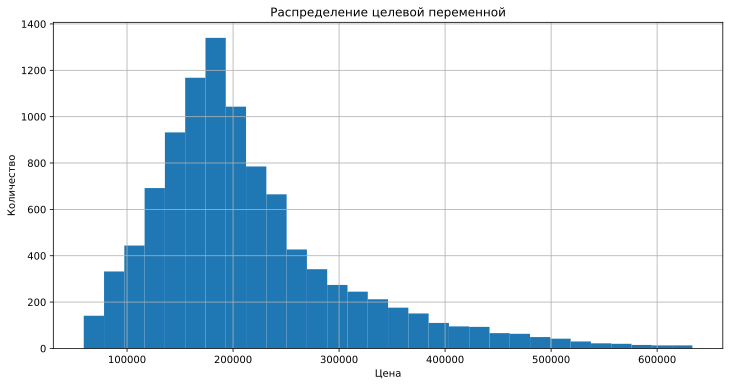

In [12]:
plt.figure(figsize = (12,6))
train['Price'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Цена')
plt.title('Распределение целевой переменной')
plt.show()

Из графика видим наличие аномальных значений цены для квартир.

#### Номинантные переменные

In [13]:
def check_on_equal_values(name):
    return np.array_equal(train[name].unique(),test[name].unique())

In [14]:
train.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
test.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

Как мы видим, количество и название номанантных переменных совпадает. Проверим совпадение значений для всех, кроме параметра `Id`.

In [16]:
check_on_equal_values('DistrictId')

False

In [17]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [18]:
check_on_equal_values('Ecology_2')

True

In [19]:
train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [20]:
check_on_equal_values('Ecology_3')

True

In [21]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [22]:
check_on_equal_values('Shops_2')

True

Как мы видим, значение совпадают для всех номенантных признаков кроме `DistrictId`

### Выбросы

#### Выбросы по параметру `Rooms`

In [23]:
train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [24]:
test['Rooms'].value_counts()

2     2030
1     1769
3     1099
4       90
5        7
6        2
0        2
17       1
Name: Rooms, dtype: int64

Мы видим преобладающее количество квартир с 1-3 комнатами и небольшое количество 4-6 комнат. Так же мы наблюдаем небольшое количество квартир с странным количеством комнат, а именно 0, 10 и 19. Будем считать эти значения выбросами и заменим на среднее значение

In [25]:
room_median = train['Rooms'].median()
train.loc[train['Rooms']==0,'Rooms'] = room_median
train.loc[train['Rooms']>6,'Rooms'] = room_median
train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947953,29.197612,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401785,30.476203,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1,47.939008,NaN,1.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2,43.602562,33.840147,8.0,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [26]:
train['Rooms'].value_counts()

2    3891
1    3705
3    2235
4     150
5      18
6       1
Name: Rooms, dtype: int64

Уберем аналогично выбросы для тестовой выборки

In [27]:
test.loc[test['Rooms']==0,'Rooms'] = room_median
test.loc[test['Rooms']>6,'Rooms'] = room_median
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2,69.263183,NaN,1.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1,13.597819,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3,67.133911,50.809797,6.0,5,9,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1,40.198472,21.807061,10.0,12,17,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3,77.842178,48.282625,9.0,23,22,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2,81.305222,NaN,0.0,4,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


#### Выбросы по параметрам `Square`, `LifeSquare` и `KitchenSquare`

Тк общая площадь квартиры должны быть больше,чем жилая и площадь кухни, то проверим данные на следующее утверждение:

`Square` > `LifeSquare` + `KitchenSquare`

Тк в поле `LifeSquare` присутствуют `NA`, будем проверять это утверждение для заполенных данных.

In [28]:
valid_square = train[train['LifeSquare'].notnull()]
valid_square = valid_square[valid_square['Square']>(valid_square['KitchenSquare'] + valid_square['LifeSquare'])]
len(valid_square)

7042

Как мы видим, существует 7042 записей для которых это условие выполняется.

В стандартных квартирах обычно `KitchenSquare` > `LifeSquare`. Проверим, что для верных данных 

In [29]:
valid_square = valid_square[valid_square['KitchenSquare']<valid_square['LifeSquare']]
len(valid_square), len(valid_square)/len(train)

(7033, 0.7033)

Как мы видим, примерно 70% данных о площадях квартир валидны. Привести эти данные к корректным довольно проблематично, поэтому мы не будем учитывать данные в столбцах `KitchenSquare` и `LifeSquare`.

In [30]:
train = train.drop(columns = ['LifeSquare', 'KitchenSquare'])
train = train[train['Square'].isnull()|(train['Square']<train['Square'].quantile(.975))|(train['Square']>train['Square'].quantile(.025))]
test = test.drop(columns = ['LifeSquare', 'KitchenSquare'])
train

,Id,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981561,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3,65.683640,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947953,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352981,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649192,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401785,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1,41.521546,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1,47.939008,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2,43.602562,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


#### Выбросы по параметрам `HouseFloor` и `Floor`

In [31]:
train['HouseFloor'].value_counts()

17     2331
9      1389
12     1074
5      1031
14      625
16      576
1       497
25      374
22      343
0       269
24      176
8       141
10      135
4       134
3       127
15      123
19      108
20      105
18       89
7        59
6        58
2        48
23       40
21       33
11       28
13       27
30       21
40        7
27        6
37        4
32        4
28        3
39        2
99        2
48        2
44        1
47        1
36        1
29        1
45        1
38        1
117       1
26        1
31        1
Name: HouseFloor, dtype: int64

In [32]:
train['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117])

Мы видим аномалию в виде домов с 0 количеством этажей, а так же 3 дома выше 50го этажа. Заменим значение 0 на медиану.

In [33]:
house_floor_median = train['HouseFloor'].median()
train.loc[train['HouseFloor'] == 0,'HouseFloor'] = house_floor_median

In [34]:
train['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
31      1
37      1
33      1
Name: Floor, dtype: int64

Проверим наличие квартир, у которых параметр `Floor` больше `HouseFloor`

In [35]:
floor_ourliers = train.loc[train['Floor']>train['HouseFloor']].index
floor_ourliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

Как мы видим, таких квартир довольно много, что явно указывает на ошибку при заполнении данных.
Произведем замену на случайное число от 1 до X, где X - это значение поля `HouseFloor` для данной квартиры

In [36]:
train.loc[floor_ourliers, 'Floor']=train.loc[floor_ourliers,'HouseFloor'].apply(lambda x: random.randint(1,x))

Аналогичные действия выполним и для тестовой выборки

In [37]:
test['HouseFloor'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 39, 40, 48, 99])

In [38]:
test.loc[test['HouseFloor'] == 0,'HouseFloor'] = house_floor_median

In [39]:
test_floor_ourliers = test.loc[test['Floor']>test['HouseFloor']].index
test_floor_ourliers

Int64Index([   1,   10,   14,   27,   32,   36,   41,   46,   55,   58,
            ...
            4956, 4957, 4958, 4962, 4964, 4968, 4972, 4989, 4993, 4997],
           dtype='int64', length=782)

In [40]:
test.loc[test_floor_ourliers, 'Floor']=test.loc[test_floor_ourliers,'HouseFloor'].apply(lambda x: random.randint(1,x))

#### Выбросы по параметру `HouseYear`

In [41]:
train['HouseYear'].sort_values(ascending=False).unique()

array([20052011,     4968,     2020,     2019,     2018,     2017,
           2016,     2015,     2014,     2013,     2012,     2011,
           2010,     2009,     2008,     2007,     2006,     2005,
           2004,     2003,     2002,     2001,     2000,     1999,
           1998,     1997,     1996,     1995,     1994,     1993,
           1992,     1991,     1990,     1989,     1988,     1987,
           1986,     1985,     1984,     1983,     1982,     1981,
           1980,     1979,     1978,     1977,     1976,     1975,
           1974,     1973,     1972,     1971,     1970,     1969,
           1968,     1967,     1966,     1965,     1964,     1963,
           1962,     1961,     1960,     1959,     1958,     1957,
           1956,     1955,     1954,     1953,     1952,     1951,
           1950,     1948,     1947,     1942,     1941,     1940,
           1939,     1938,     1937,     1936,     1935,     1934,
           1933,     1932,     1931,     1930,     1929,     1

In [42]:
train.loc[train['HouseYear'].isin([20052011, 4968]),'HouseYear'].value_counts()

20052011    1
4968        1
Name: HouseYear, dtype: int64

In [43]:
train[(train['HouseYear']!=20052011) & (train['HouseYear']!=4968) & (train['HouseYear']>2000)]['HouseYear'].value_counts()

2017    308
2016    305
2015    299
2014    210
2018    175
2005    102
2004     99
2009     96
2013     95
2007     95
2008     95
2011     91
2003     89
2010     85
2019     79
2006     78
2002     77
2012     75
2001     62
2020     19
Name: HouseYear, dtype: int64

Как мы видим, у нас присутствуют странные значения для двух квартир - 20052011 и 4968. Так же мы видим небольшое число квартир за 2020 год. Будем считать, что квартиры с значением `HouseYear` > 2020 на самом деле 2020го года строительства.

In [44]:
train.loc[train['HouseYear']>2020,'HouseYear']=2020
test.loc[test['HouseYear']>2020,'HouseYear']=2020

### Обработка пропусков

In [45]:
len(train) - train.count()

Id                 0
DistrictId         0
Rooms              0
Square             0
Floor              0
HouseFloor         0
HouseYear          0
Ecology_1          0
Ecology_2          0
Ecology_3          0
Social_1           0
Social_2           0
Social_3           0
Healthcare_1    4798
Helthcare_2        0
Shops_1            0
Shops_2            0
Price              0
dtype: int64

In [46]:
len(test) - test.count()

Id                 0
DistrictId         0
Rooms              0
Square             0
Floor              0
HouseFloor         0
HouseYear          0
Ecology_1          0
Ecology_2          0
Ecology_3          0
Social_1           0
Social_2           0
Social_3           0
Healthcare_1    2377
Helthcare_2        0
Shops_1            0
Shops_2            0
dtype: int64

Мы видим, что пропуски есть в параметре `Healthcare_1`. Для заполнения пропусков воспользуемся медианным значением:

In [47]:
healthcare_1_median = train['Healthcare_1'].median()
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = healthcare_1_median
test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = healthcare_1_median

### Построение новых признаков

#### Dummies

Подготовим dummies переменные к модели данных

In [48]:
def replace_dummies(data):
    data['Ecology_2_bin'] = data['Ecology_2'].replace({'A':0, 'B':1})
    data['Ecology_3_bin'] = data['Ecology_3'].replace({'A':0, 'B':1})
    data['Shops_2_bin'] = data['Shops_2'].replace({'A':0, 'B':1})
    return data.drop(columns = ['Ecology_2','Ecology_3','Shops_2'])

In [49]:
train = replace_dummies(train)
test = replace_dummies(test)

#### DistrinctSize, IsDistrictLarge

Посмотрим на размеры регионов

In [50]:
district_size = train['DistrictId'].value_counts().reset_index().rename(columns = {'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [51]:
train = train.merge(district_size, on='DistrictId', how='left')
train.head()

,Id,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2,47.981561,7,9,1969,0.089040,33,7976,5,900.0,0,11,184966.930730,1,1,1,22
1,15053,41,3,65.683640,7,9,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1,87
2,4765,53,2,44.947953,8,12,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,1,1,1,174
3,5809,58,2,53.352981,8,17,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217,1,1,1,179
4,10783,99,1,39.649192,11,12,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644,1,1,1,97


Смержим полученные размеры районов с тестовой выборкой, а пропуски заполним средним значением.

In [52]:
test = test.merge(district_size, on='DistrictId', how='left')
test.loc[test['DistrictSize'].isnull(), 'DistrictSize'] = district_size['DistrictSize'].median()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   int32  
 3   Square         5000 non-null   float64
 4   Floor          5000 non-null   int64  
 5   HouseFloor     5000 non-null   int32  
 6   HouseYear      5000 non-null   int64  
 7   Ecology_1      5000 non-null   float64
 8   Social_1       5000 non-null   int64  
 9   Social_2       5000 non-null   int64  
 10  Social_3       5000 non-null   int64  
 11  Healthcare_1   5000 non-null   float64
 12  Helthcare_2    5000 non-null   int64  
 13  Shops_1        5000 non-null   int64  
 14  Ecology_2_bin  5000 non-null   int64  
 15  Ecology_3_bin  5000 non-null   int64  
 16  Shops_2_bin    5000 non-null   int64  
 17  DistrictSize   5000 non-null   float64
dtypes: float

<AxesSubplot:xlabel='DistrictSize', ylabel='MedianPrice'>

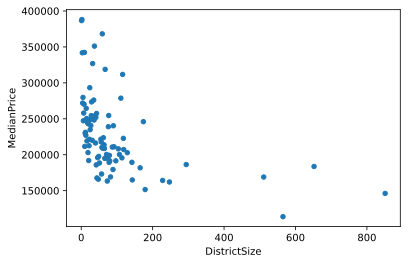

In [53]:
train.groupby(['DistrictSize'], as_index=False).agg({'Price':'median'}).rename(columns = {'Price':'MedianPrice'}).plot.scatter(x = 'DistrictSize', y = 'MedianPrice')

Будем считать, что все районы с количеством квартир больше 100 - большие.

In [54]:
train['IsDistrictLarge'] = (train['DistrictSize']>100).astype(int)
test['IsDistrictLarge'] = (test['DistrictSize']>100).astype(int)

#### MedRoomPriceByDistrict

Посчитаем среднюю цену квартиры по районам.

In [55]:
med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns = {'Price':'MedRoomPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedRoomPriceByDistrict
0,0,1,142799.434052
1,0,2,176210.812334
2,0,3,300610.359425
3,1,1,146735.671740
4,1,2,202666.310126


In [56]:
train = train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedRoomPriceByDistrict
0,14038,35,2,47.981561,7,9,1969,0.089040,33,7976,...,900.0,0,11,184966.930730,1,1,1,22,0,207786.135836
1,15053,41,3,65.683640,7,9,1978,0.000070,46,10309,...,240.0,1,16,300009.450063,1,1,1,87,0,300009.450063
2,4765,53,2,44.947953,8,12,1968,0.049637,34,7759,...,229.0,1,3,220925.908524,1,1,1,174,1,263206.223152
3,5809,58,2,53.352981,8,17,1977,0.437885,23,5735,...,1084.0,0,5,175616.227217,1,1,1,179,1,166809.665642
4,10783,99,1,39.649192,11,12,1976,0.012339,35,5776,...,2078.0,2,4,150226.531644,1,1,1,97,0,158539.052715


Применим полученные данные для тестовой выборки, а пропуски заполним средним значением

In [57]:
med_district_price_by_room = med_price_by_district.groupby(['Rooms'], as_index=False).agg({'MedRoomPriceByDistrict':'median'})
med_district_price_by_room.head(7)

,Rooms,MedRoomPriceByDistrict
0,1,180781.664352
1,2,233260.805751
2,3,322079.709280
3,4,392798.072990
4,5,458562.566093
5,6,229661.964416


In [58]:
test = test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test = test.merge(med_district_price_by_room, on=['Rooms'], how='left')
test['MedRoomPriceByDistrict'] = test['MedRoomPriceByDistrict_x']
test.loc[test['MedRoomPriceByDistrict'].isnull(), 'MedRoomPriceByDistrict'] = test.loc[test['MedRoomPriceByDistrict'].isnull(),'MedRoomPriceByDistrict_y']
test = test.drop(columns = ['MedRoomPriceByDistrict_x', 'MedRoomPriceByDistrict_y'])
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      5000 non-null   object 
 1   DistrictId              5000 non-null   object 
 2   Rooms                   5000 non-null   int32  
 3   Square                  5000 non-null   float64
 4   Floor                   5000 non-null   int64  
 5   HouseFloor              5000 non-null   int32  
 6   HouseYear               5000 non-null   int64  
 7   Ecology_1               5000 non-null   float64
 8   Social_1                5000 non-null   int64  
 9   Social_2                5000 non-null   int64  
 10  Social_3                5000 non-null   int64  
 11  Healthcare_1            5000 non-null   float64
 12  Helthcare_2             5000 non-null   int64  
 13  Shops_1                 5000 non-null   int64  
 14  Ecology_2_bin           5000 non-null   

#### MedSquarePriceByDistrict

Посчитаем среднюю цену квадрата по району

In [59]:
train_with_price_by_square = train.copy()
train_with_price_by_square['PriceBySquare'] = train['Price']/train['Square']
train_with_price_by_square

,Id,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedRoomPriceByDistrict,PriceBySquare
0,14038,35,2,47.981561,7,9,1969,0.089040,33,7976,...,0,11,184966.930730,1,1,1,22,0,207786.135836,3854.958571
1,15053,41,3,65.683640,7,9,1978,0.000070,46,10309,...,1,16,300009.450063,1,1,1,87,0,300009.450063,4567.491245
2,4765,53,2,44.947953,8,12,1968,0.049637,34,7759,...,1,3,220925.908524,1,1,1,174,1,263206.223152,4915.149522
3,5809,58,2,53.352981,8,17,1977,0.437885,23,5735,...,0,5,175616.227217,1,1,1,179,1,166809.665642,3291.591637
4,10783,99,1,39.649192,11,12,1976,0.012339,35,5776,...,2,4,150226.531644,1,1,1,97,0,158539.052715,3788.892642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401785,5,5,1968,0.135650,46,7960,...,3,11,196684.316040,1,1,1,34,0,233599.115975,3902.328381
9996,6159,18,1,41.521546,13,13,2000,0.000000,30,5562,...,0,5,189050.289571,1,1,0,51,0,171162.179903,4553.064815
9997,5123,27,1,47.939008,12,16,2015,0.072158,2,629,...,0,0,159143.805370,1,1,0,851,1,118327.090620,3319.714218
9998,5400,75,2,43.602562,1,5,1961,0.307467,30,5048,...,2,5,181595.339808,1,0,1,66,0,187966.419078,4164.786044


In [60]:
med_price_by_square = train_with_price_by_square.groupby(['DistrictId','Rooms'], as_index=False).agg({'PriceBySquare':'median'}).rename(columns={'PriceBySquare': 'MedSquarePriceByDistrict'})
med_price_by_square.head()

,DistrictId,Rooms,MedSquarePriceByDistrict
0,0,1,4014.374409
1,0,2,3697.857111
2,0,3,4405.321283
3,1,1,3427.367727
4,1,2,3205.262775


In [61]:
train = train.merge(med_price_by_square, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedRoomPriceByDistrict,MedSquarePriceByDistrict
0,14038,35,2,47.981561,7,9,1969,0.089040,33,7976,...,0,11,184966.930730,1,1,1,22,0,207786.135836,4327.450809
1,15053,41,3,65.683640,7,9,1978,0.000070,46,10309,...,1,16,300009.450063,1,1,1,87,0,300009.450063,4334.638453
2,4765,53,2,44.947953,8,12,1968,0.049637,34,7759,...,1,3,220925.908524,1,1,1,174,1,263206.223152,4803.111190
3,5809,58,2,53.352981,8,17,1977,0.437885,23,5735,...,0,5,175616.227217,1,1,1,179,1,166809.665642,2811.234060
4,10783,99,1,39.649192,11,12,1976,0.012339,35,5776,...,2,4,150226.531644,1,1,1,97,0,158539.052715,4242.303429


Применим полученные данные для тестовой выборки, а пропуски заполним средним значением

In [62]:
med_square_price_by_district = med_price_by_square.groupby(['Rooms'], as_index=False).agg({'MedSquarePriceByDistrict':'median'})
med_square_price_by_district.head(7)

,Rooms,MedSquarePriceByDistrict
0,1,4802.522615
1,2,4653.625532
2,3,4406.943733
3,4,4235.395294
4,5,3959.462127
5,6,3865.430271


In [63]:
test = test.merge(med_price_by_square, on=['DistrictId', 'Rooms'], how='left')
test = test.merge(med_square_price_by_district, on=['Rooms'], how='left')
test['MedSquarePriceByDistrict'] = test['MedSquarePriceByDistrict_x']
test.loc[test['MedSquarePriceByDistrict'].isnull(), 'MedSquarePriceByDistrict'] = test.loc[test['MedSquarePriceByDistrict'].isnull(),'MedSquarePriceByDistrict_y']
test = test.drop(columns = ['MedSquarePriceByDistrict_x', 'MedSquarePriceByDistrict_y'])
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        5000 non-null   object 
 1   DistrictId                5000 non-null   object 
 2   Rooms                     5000 non-null   int32  
 3   Square                    5000 non-null   float64
 4   Floor                     5000 non-null   int64  
 5   HouseFloor                5000 non-null   int32  
 6   HouseYear                 5000 non-null   int64  
 7   Ecology_1                 5000 non-null   float64
 8   Social_1                  5000 non-null   int64  
 9   Social_2                  5000 non-null   int64  
 10  Social_3                  5000 non-null   int64  
 11  Healthcare_1              5000 non-null   float64
 12  Helthcare_2               5000 non-null   int64  
 13  Shops_1                   5000 non-null   int64  
 14  Ecology_

In [64]:
train.describe()

,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedRoomPriceByDistrict,MedSquarePriceByDistrict
count,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315775,7.41700,12.95910,1984.872400,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,242.306600,0.506900,211504.274006,3916.570316
std,0.812096,21.058732,5.03677,6.44346,18.416347,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,268.992652,0.499977,76545.354083,1042.926958
min,1.000000,1.136859,1.00000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,1.000000,0.000000,82342.775873,810.825491
25%,1.000000,41.774881,3.00000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,55.000000,0.000000,165071.825722,3001.168657
50%,2.000000,52.513310,6.00000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,104.000000,1.000000,195474.299127,4065.045010
75%,2.000000,65.900625,11.00000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,511.000000,1.000000,241068.903045,4593.951987
max,6.000000,641.065193,42.00000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,851.000000,1.000000,624156.003381,11854.652892


### Отбор признаков

In [65]:
feature_names = ['Rooms', 'Square', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 'IsDistrictLarge', 'MedRoomPriceByDistrict', 'MedSquarePriceByDistrict']
X = train[feature_names]
y = train['Price']

### Разбиение на тестовую и тренировочную выборку

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42)

### Построение модели

In [67]:
model = RandomForestRegressor(n_estimators = 1000, max_depth = 12, random_state = 42)
model.fit(X_train, y_train.values[:])
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)
R2_train = r2_score(y_train, y_train_preds)
R2_test = r2_score(y_test, y_test_preds)
R2_train, R2_test

(0.9287167127564797, 0.7472585919817557)

In [68]:
cv_score = cross_val_score(model, X, y, scoring='r2', cv=KFold(n_splits=3,shuffle=True,random_state=42))
cv_score

array([0.74901296, 0.74650897, 0.77650135])

In [69]:
cv_score.mean()

0.7573410928817464

### Важность признаков

In [70]:
feature_importances =pd.DataFrame(zip(X_train.columns, model.feature_importances_), columns=['feature_name','importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
16,MedRoomPriceByDistrict,0.645359
1,Square,0.150270
17,MedSquarePriceByDistrict,0.068378
4,HouseYear,0.025914
2,Floor,0.018852
3,HouseFloor,0.017657
8,Social_3,0.012670
5,Ecology_1,0.012466
7,Social_2,0.012220
6,Social_1,0.010757


### Предсказание для тестовой выборки

In [71]:
preds = model.predict(test[feature_names])
preds

array([161870.9923202 , 228500.13096966, 146139.29367173, ...,
       312818.1123972 , 186386.40026279, 173282.19191039])

In [72]:
result = test.copy()
result['Price'] = preds
result = result.drop(columns = ['DistrictId','Rooms','Square','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','Healthcare_1','Helthcare_2','Shops_1','Ecology_2_bin','Ecology_3_bin','Shops_2_bin','DistrictSize','IsDistrictLarge','MedRoomPriceByDistrict','MedSquarePriceByDistrict'])
result.head()

,Id,Price
0,725,161870.992320
1,15856,228500.130970
2,5480,146139.293672
3,15664,310735.890473
4,14275,139788.076752


In [73]:
result.to_csv('AKarpov_predictions.csv')